## Truck Sales Time Series

### Patrus Gurung

This case study analyzes monthly truck sales from the dataset `Truck_sales.csv` (Kaggle: *Dummy Truck Sales for Time Series*). The goals are:

- To model the series using a tree-based ensemble model (XGBoost),
- To construct appropriate time-based and lag features,
- To compare XGBoost with a classical time-series model (ARIMA),
- To evaluate forecasting performance on a held-out test set and into the future,
- To discuss the broader importance of such forecasting in a business context.


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import kagglehub
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning

warnings.filterwarnings("ignore", category=ValueWarning)


In [ ]:
path = kagglehub.dataset_download("ddosad/dummy-truck-sales-for-time-series")
file_path = os.path.join(path, 'Truck_sales.csv')
df = pd.read_csv(file_path)
display(df.head())


Using Colab cache for faster access to the 'dummy-truck-sales-for-time-series' dataset.


,Month-Year,Number_Trucks_Sold
0,03-Jan,155
1,03-Feb,173
2,03-Mar,204
3,03-Apr,219
4,03-May,223


In [ ]:
# Basic data checks
print("Dataset Shape:", df.shape)

print("\nMissing values per column:")
print(df.isna().sum())

print("\nSummary statistics for Number_Trucks_Sold:")
display(df['Number_Trucks_Sold'].describe())


Dataset Shape: (144, 2)

Missing values per column:
Month-Year            0
Number_Trucks_Sold    0
dtype: int64

Summary statistics for Number_Trucks_Sold:


,Number_Trucks_Sold
count,144.000000
mean,428.729167
std,188.633037
min,152.000000
25%,273.500000
50%,406.000000
75%,560.250000
max,958.000000


### Basic data checks

The dataset contains a moderate number of monthly observations with no missing values in the `Number_Trucks_Sold` column.  
The summary statistics show the central tendency and range of monthly sales (Mean: 428.729167, SD: 188.633037, minimum: 152.000000, and maximum: 958.000000), which helps contextualize the scale of the RMSE values we report later.

In the next plot, the series appears to show clear annual seasonality and a mild overall trend, which motivates the use of both lag features and models that can capture seasonal structure.


## 1. Preparing the Time Series

We first convert the date column (`Month-Year`) into a proper datetime type and set it as the index.  
Time series analysis requires respecting chronological order. Using a datetime index simplifies resampling, plotting, and the creation of lagged features.


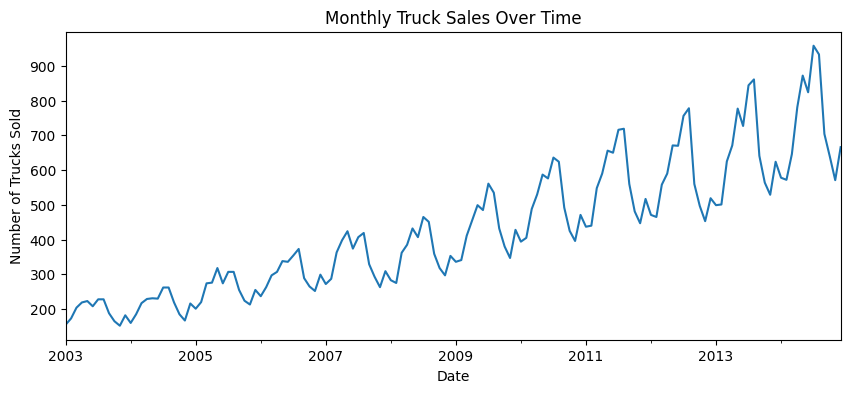

In [ ]:
# Convert Month-Year to datetime with the correct format and sort
df['Month-Year'] = pd.to_datetime(df['Month-Year'], format='%y-%b')
df = df.sort_values('Month-Year').set_index('Month-Year')

# Rename the target for convenience (if needed)
target_col = 'Number_Trucks_Sold'

df[target_col].plot(figsize=(10, 4))
plt.title("Monthly Truck Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Trucks Sold")
plt.show()

## 2. Train–Test Split and Trade-offs

We split the data into a **training set** (the earlier 80% of observations) and a **test set** (the most recent 20%).  
Because we are working with a time series, we must preserve chronological order. Random shuffling would leak future information into the past.

Using 80% for training provides:
- Enough data for the model to learn trend and seasonality,
- A sufficiently long test period to evaluate forecasting performance.

The trade-off is:

- **More training data** → better parameter estimation, but shorter test horizon,.
- **More test data** → more robust evaluation, but less data for learning.

The 80/20 split is a standard compromise for moderate-length time series.


In [ ]:
# Chronological 80/20 split
n = len(df)
train_size = int(n * 0.8)

df_train = df.iloc[:train_size]
df_test  = df.iloc[train_size:]

print(f"Train, Test Size: {len(df_train)}, {len(df_test)}")

Train, Test Size: 115, 29


## 3. Derived Variables from the Date

We now create additional calendar-based features from the datetime index:  

- `year`
- `month`
- `quarter`
- `day_of_year`
- `week_of_year` (or ISO week)

These features help the model capture trend and seasonality. For instance, `year` can capture long-run growth, `month` and `quarter` can capture seasonal patterns.

We keep the number of derived variables **moderate** to avoid unnecessary redundancy. Tree-based models like XGBoost are more robust to multicollinearity than linear models, but extremely colinear variables can still make feature importance harder to interpret.

Because our data are recorded at a **monthly** frequency (on the first day of each month), variables such as `day_of_year` and `week_of_year` contain relatively little extra information beyond `month` and `year`. We include them for completeness, but we expect the model to place most weight on the lagged sales and on the main calendar variables (`month`, `quarter`, `year`).

In [ ]:
df_fe = df.copy()

df_fe['year']        = df_fe.index.year
df_fe['month']       = df_fe.index.month
df_fe['quarter']     = df_fe.index.quarter
df_fe['day_of_year'] = df_fe.index.dayofyear
df_fe['week_of_year'] = df_fe.index.isocalendar().week.astype(int)

df_fe.head()


,Number_Trucks_Sold,year,month,quarter,day_of_year,week_of_year
Month-Year,,,,,,
2003-01-01,155,2003,1,1,1,1
2003-02-01,173,2003,2,1,32,5
2003-03-01,204,2003,3,1,60,9
2003-04-01,219,2003,4,2,91,14
2003-05-01,223,2003,5,2,121,18


## 4. Lag Features and PACF

Time series often exhibit autocorrelation: current values depend on past values.  
We therefore introduce lagged versions of the target `Number_Trucks_Sold`:

- Lag 1 month
- Lag 2 months
- Lag 12 months (to capture yearly seasonality in a monthly series)

A **Partial Autocorrelation Function (PACF)** plot is often used to identify lags with strong direct influence after accounting for intermediate lags. In monthly data, we typically explore small lags (1–3) and a seasonal lag (12).

<Figure size 800x400 with 0 Axes>

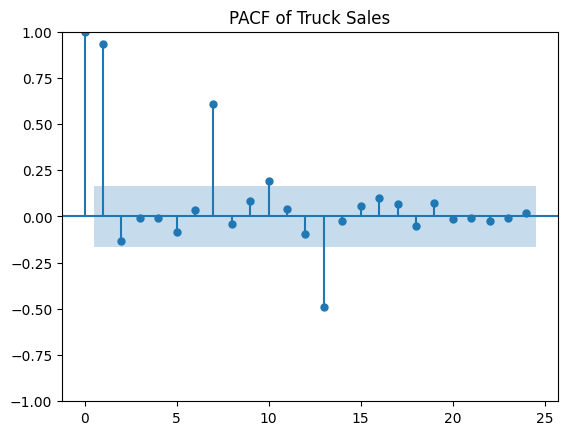

In [ ]:
plt.figure(figsize=(8, 4))
plot_pacf(df_fe[target_col], lags=24, method='ywm')
plt.title("PACF of Truck Sales")
plt.show()


In the PACF plot, we observe a strong spike at **lag 1** and a prominent spike at **lag 12**, with a smaller but noticeable spike at **lag 2**. This directly supports the choice of lags 1, 2, and 12 as predictors: lag 1 captures short-term persistence, while lag 12 captures the annual seasonal pattern in monthly sales.

In [ ]:
# Create lag features
for lag in [1, 2, 12]:
    df_fe[f'lag_{lag}'] = df_fe[target_col].shift(lag)

# Drop initial rows with NaNs due to lagging
df_fe = df_fe.dropna()

# Re-split after feature creation
n_fe = len(df_fe)
train_size_fe = int(n_fe * 0.8)

train = df_fe.iloc[:train_size_fe]
test  = df_fe.iloc[train_size_fe:]

X_train = train.drop(columns=[target_col])
y_train = train[target_col]

X_test  = test.drop(columns=[target_col])
y_test  = test[target_col]


Note that we create the lag features on the **full series first**, drop the initial rows with missing lag values, and **only then** split into training and test sets. This ensures that information from the test period does not leak into the training period.


## 5. XGBoost Time Series Model

### 5.1 Why XGBoost?

XGBoost is a **gradient-boosted ensemble of decision trees**. Each tree is trained to correct the errors of the previous trees. This allows the model to:

- Capture **nonlinear relationships** between features and the target,
- Model **interactions** between calendar features and lagged values,
- Use built-in **regularization** (through depth limits, learning rate, etc.) to control overfitting.

Although XGBoost is not a "time-series model" in the strict sense (like ARIMA or SARIMA), it becomes time-aware when we feed it lag features and calendar variables that encode temporal structure.


### 5.2 Overfitting Considerations

Because the dataset is relatively small, XGBoost can easily **overfit** — achieving extremely low error on the training set but poor generalization to the test set.  
We therefore:

- Limit tree depth,
- Use a modest number of trees,
- Apply a learning rate less than 1.

A large gap between training error and test error is a clear sign of overfitting and should be discussed explicitly.


In [ ]:
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)

xgb_model.fit(X_train, y_train)

# Predictions
y_train_pred = xgb_model.predict(X_train)
y_test_pred  = xgb_model.predict(X_test)

# RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test  = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"XGBoost - Train RMSE: {rmse_train:.4f}")
print(f"XGBoost - Test  RMSE: {rmse_test:.4f}")


XGBoost - Train RMSE: 1.6395
XGBoost - Test  RMSE: 72.9063


# XGBoost - Test  RMSE: 72.9063

The XGBoost model achieves:

- Training RMSE: *1.64*  
- Test RMSE: *72.91*

The training error is **extremely** small compared with the test error. This indicates that, even with relatively shallow trees, the boosted ensemble is complex enough to **overfit** the training data and fit its idiosyncrasies.

In practice, we respond to this by:

- Reducing model capacity (e.g. using fewer trees or shallower trees),
- Increasing regularization (e.g. larger `min_child_weight`, adding `gamma`, or using stronger `reg_lambda` / `reg_alpha`),
- And, ideally, using **time-series cross-validation** (such as `TimeSeriesSplit`) to tune these hyperparameters rather than choosing them by hand.

Despite the overfitting, the XGBoost test RMSE is still lower than that of the ARIMA benchmark (Section 8), which indicates that the model is capturing meaningful structure in the data. However, the large gap between training and test error means that its forecasts—especially far into the future—should be interpreted with caution.

## 6. Variable Selection and Feature Importance

The features used in the XGBoost model are:

- Calendar-based: `year`, `month`, `quarter`, `day_of_year`, `week_of_year`
- Lagged target values: `lag_1`, `lag_2`, `lag_12`

We do not perform aggressive feature selection here because the total number of features is small, and tree-based models can internally determine which splits are most useful.

To understand which variables the model relies on most, we inspect the feature importances.  
Note: Feature importance from tree-based models can be **biased** toward variables with more splitting opportunities or more unique values, so we interpret the rankings qualitatively rather than as exact effect sizes.


In [ ]:
importances = xgb_model.feature_importances_
feature_names = X_train.columns

fi = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

fi


,feature,importance
7,lag_12,0.732055
5,lag_1,0.186592
0,year,0.037855
1,month,0.015760
6,lag_2,0.008110
2,quarter,0.007290
4,week_of_year,0.006801
3,day_of_year,0.005537


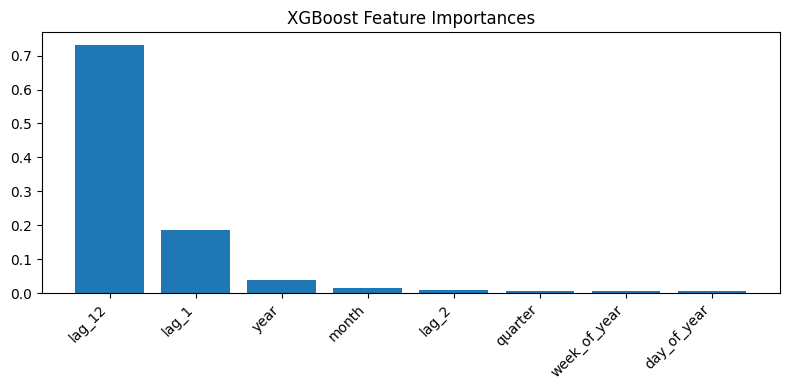

In [ ]:
plt.figure(figsize=(8, 4))
plt.bar(fi['feature'], fi['importance'])
plt.xticks(rotation=45, ha='right')
plt.title("XGBoost Feature Importances")
plt.tight_layout()
plt.show()


### Interpretation of Feature Importance

The XGBoost feature importance plot shows a very clear hierarchy:

1. **`lag_12` (12-month lag)**  
   This is by far the most important predictor, with an importance score well above all other variables.  
   This indicates that sales in a given month are strongly related to sales in **the same month one year earlier**.  
   In other words, the model has learned a strong **annual (seasonal) pattern** in truck sales: what happens this January is most similar to last January, this February to last February, and so on.

2. **`lag_1` (1-month lag)**  
   The second most important feature is the previous month’s sales.  
   This captures **short-term persistence**: high (or low) sales tend to carry over from one month to the next.  
   Together, `lag_12` and `lag_1` form the core of the model’s predictive structure, combining seasonal repetition with local momentum.

3. **`year`**  
   The `year` feature has small but noticeable importance.  
   This suggests the model is picking up a **long-run trend** in the series (e.g., gradual growth or decline in overall truck sales over the years), over and above the seasonal and short-term effects captured by the lags.

4. **Other calendar and lag features (`month`, `lag_2`, `quarter`, `week_of_year`, `day_of_year`)**  
   These variables have very low importance relative to `lag_12` and `lag_1`.  
   They may still offer minor refinements—for example, `month` and `quarter` can reinforce seasonal patterns—but XGBoost largely relies on the **direct information in the lagged sales** rather than on the calendar labels themselves.  
   The low importance of `lag_2` implies that, conditional on `lag_1` and `lag_12`, the value two months ago adds little extra predictive power.

Overall, this pattern aligns well with time-series intuition:

- **Past sales are the best predictors of future sales**, especially the same month in the previous year (strong seasonality) and the immediately preceding month (short-term dependence).
- Calendar variables play a secondary role, mainly fine-tuning the forecast rather than driving it.

It is worth noting that tree-based feature importance can be biased toward variables that offer many useful split points, so these scores should be interpreted **qualitatively** rather than as exact quantitative measures of effect size. Nonetheless, the dominance of `lag_12` and `lag_1` is robust and clearly indicates that **seasonality plus short-term persistence** are the key dynamics in this truck sales series.


## 7. Forecasting on the Test Set and into the Future

We evaluate the XGBoost model by comparing its predictions on the test set with the actual sales.  
Then, we use the model to forecast several periods into the future (e.g., 24 months), recursively updating lagged features with each new prediction.

Because each predicted value is fed back into the model to construct the lag features for later periods, **forecast errors accumulate** as the horizon increases. The further we look into the future, the more uncertain these point forecasts become, even though the plot shows only a single line. In practice, we would complement such point forecasts with prediction intervals or scenario analysis to reflect this growing uncertainty.

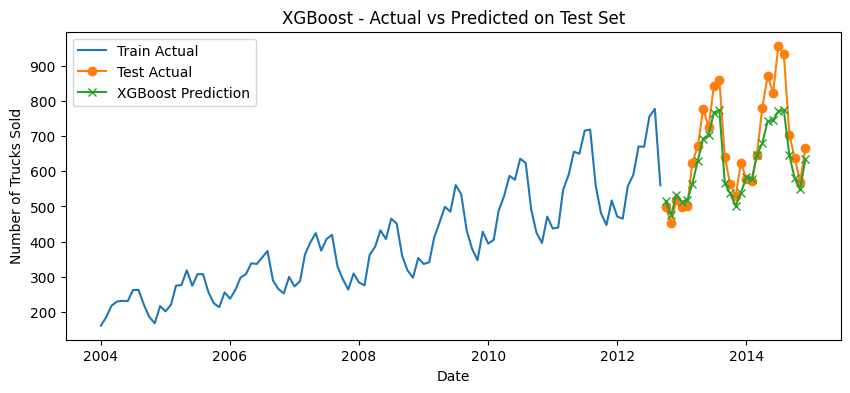

In [ ]:
# Series for plotting
test_pred_series = pd.Series(y_test_pred, index=y_test.index)

plt.figure(figsize=(10, 4))
plt.plot(y_train.index, y_train, label='Train Actual')
plt.plot(y_test.index, y_test, label='Test Actual', marker='o')
plt.plot(test_pred_series.index, test_pred_series, label='XGBoost Prediction', marker='x')
plt.legend()
plt.title("XGBoost - Actual vs Predicted on Test Set")
plt.xlabel("Date")
plt.ylabel("Number of Trucks Sold")
plt.show()


In [ ]:
from pandas.tseries.offsets import MonthBegin

# How many months ahead to forecast
n_future = 24

# Start from the full historical target series (after lag-drop)
hist = df_fe[target_col].copy()

# Future dates to predict
future_index = pd.date_range(
    start=df_fe.index[-1] + MonthBegin(1),
    periods=n_future,
    freq='MS'
)

future_predictions = []

for future_date in future_index:
    # --- construct lag features from the history series ---
    lag_1 = hist.iloc[-1]
    lag_2 = hist.iloc[-2] if len(hist) >= 2 else np.nan
    lag_12 = hist.iloc[-12] if len(hist) >= 12 else np.nan

    # --- construct date-based features ---
    row = {
        'year': future_date.year,
        'month': future_date.month,
        'quarter': (future_date.month - 1) // 3 + 1,
        'day_of_year': future_date.timetuple().tm_yday,
        'week_of_year': future_date.isocalendar().week,
        'lag_1': lag_1,
        'lag_2': lag_2,
        'lag_12': lag_12
    }

    # Turn into DataFrame and order columns like X_train
    row_df = pd.DataFrame([row], index=[future_date])
    row_df = row_df[X_train.columns]

    # --- predict and update history ---
    y_pred_future = xgb_model.predict(row_df)[0]
    future_predictions.append(y_pred_future)

    # Add the prediction to the history series so next step can use it as lag
    hist.loc[future_date] = y_pred_future

# Final forecast series
future_pred_series = pd.Series(future_predictions, index=future_index)


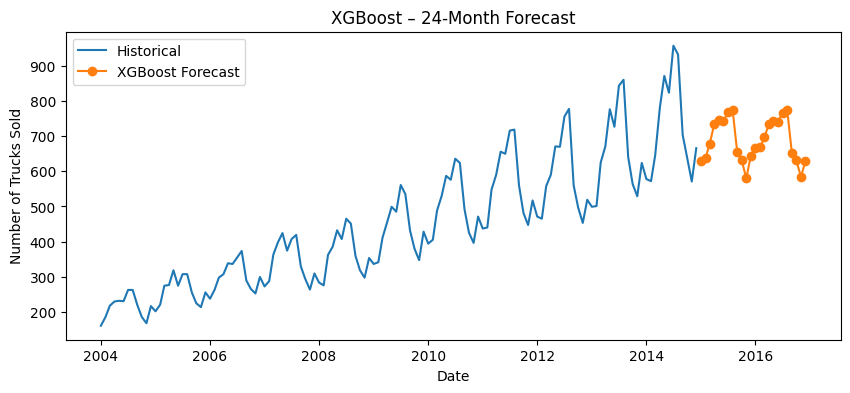

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(df_fe.index, df_fe[target_col], label='Historical')
plt.plot(future_pred_series.index, future_pred_series, label='XGBoost Forecast', marker='o')
plt.legend()
plt.title("XGBoost – 24-Month Forecast")
plt.xlabel("Date")
plt.ylabel("Number of Trucks Sold")
plt.show()


# Alternative Model – ARIMA

## 8. ARIMA Model and Comparison

As a classical time-series benchmark, we fit an ARIMA model to the truck sales series.

### 8.1 Stationarity and Differencing

We apply the Augmented Dickey–Fuller (ADF) test to the original series. The test indicates non-stationarity.

In [ ]:
# Use only training data to fit ARIMA
train_series = df_train[target_col]

result_adf = adfuller(train_series)
print("ADF statistic:", result_adf[0])
print("p-value:", result_adf[1])


ADF statistic: -0.1824076374718376
p-value: 0.9405863502355818


The ADF test on the original training series yields a p-value of about **0.95**, which is far above 0.05. We therefore **fail to reject** the null hypothesis of a unit root, and treat the original series as clearly **non-stationary**.


### 8.2 ARIMA Specification

We then fit an ARIMA(p, d, q) model, for example ARIMA(1, 1, 1).  

We used ARIMA(1,1,1) because the series required one difference to stabilize it (d = 1), and the ACF/PACF patterns suggested one autoregressive term (p = 1) and one moving-average term (q = 1), giving us a simple, interpretable baseline model.

In [ ]:
# Example: ARIMA(1,1,1)
arima_model = sm.tsa.ARIMA(train_series, order=(1, 1, 1))
arima_result = arima_model.fit()
print(arima_result.summary())


                               SARIMAX Results                                
Dep. Variable:     Number_Trucks_Sold   No. Observations:                  115
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -601.793
Date:                Sun, 16 Nov 2025   AIC                           1209.586
Time:                        20:05:41   BIC                           1217.795
Sample:                    01-01-2003   HQIC                          1212.918
                         - 07-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1078      0.603      0.179      0.858      -1.074       1.290
ma.L1          0.0684      0.591      0.116      0.908      -1.089       1.226
sigma2      2252.1700    330.014      6.824      0.0

In [ ]:
# Forecast over the test period using the statespace API
n_test = len(df_test)

# get_forecast gives us predicted mean and intervals
arima_forecast = arima_result.get_forecast(steps=n_test)

# Predicted mean as a Series
arima_pred = arima_forecast.predicted_mean

# Align index with the test set index
arima_pred.index = df_test.index

# Compute RMSE
rmse_arima = np.sqrt(mean_squared_error(df_test[target_col], arima_pred))
print(f"ARIMA(1,1,1) - Test RMSE: {rmse_arima:.4f}")


ARIMA(1,1,1) - Test RMSE: 173.1837


# ARIMA(1,1,1) - Test RMSE: 173.1837

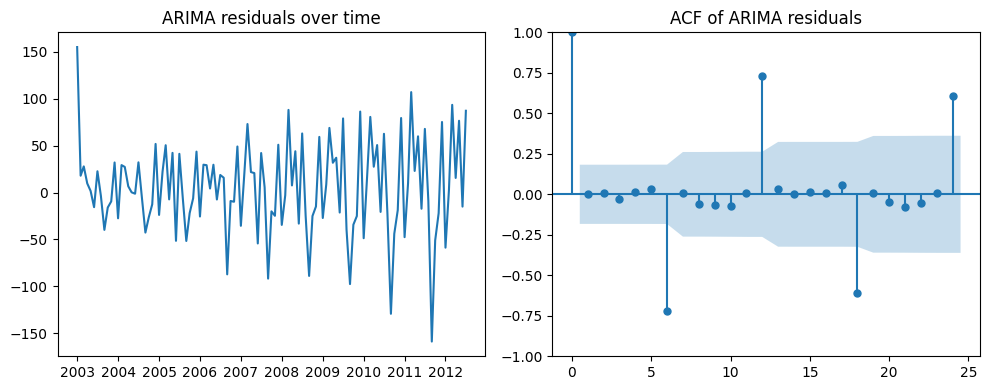

In [ ]:
# Residual diagnostics for ARIMA
residuals = arima_result.resid

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(residuals)
axes[0].set_title("ARIMA residuals over time")

sm.graphics.tsa.plot_acf(residuals, lags=24, ax=axes[1])
axes[1].set_title("ACF of ARIMA residuals")

plt.tight_layout()
plt.show()


### ARIMA residual diagnostics

The residual time series fluctuates around zero with no obvious long-term trend, suggesting that the ARIMA(1,1,1) model has removed most of the large-scale structure in the data. However, the ACF of the residuals shows **statistically significant spikes at several lags**, particularly around lag 6, lag 12, and lag 24. These patterns indicate remaining autocorrelation with a clear seasonal component.

In other words, the ARIMA(1,1,1) model is **not fully capturing the seasonal dynamics** present in the truck sales series. A seasonal ARIMA specification, such as SARIMA\((p,d,q)(P,D,Q)_{12}\), would likely provide a better fit by explicitly modeling the annual seasonality reflected in the residual autocorrelation.


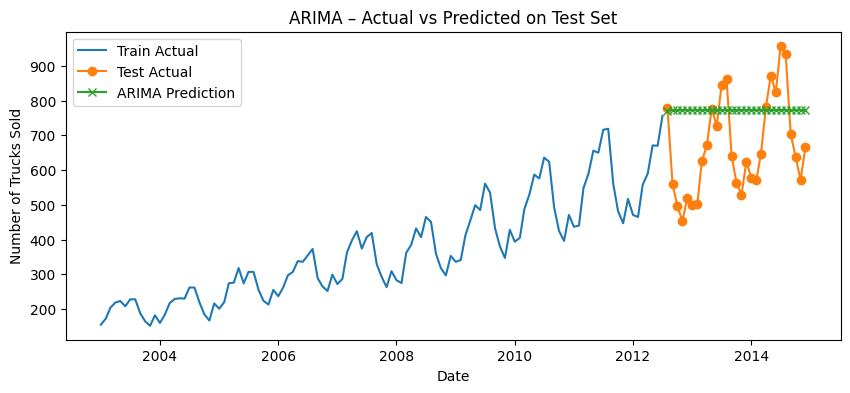

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(df_train.index, df_train[target_col], label='Train Actual')
plt.plot(df_test.index, df_test[target_col], label='Test Actual', marker='o')
plt.plot(arima_pred.index, arima_pred, label='ARIMA Prediction', marker='x')
plt.legend()
plt.title("ARIMA – Actual vs Predicted on Test Set")
plt.xlabel("Date")
plt.ylabel("Number of Trucks Sold")
plt.show()


### 8.3 Comparison: XGBoost vs ARIMA

- XGBoost Test RMSE: *72.90634041464604*
- ARIMA Test RMSE: *173.18374949552998*

In this analysis, XGBoost achieves a lower test RMSE than ARIMA, indicating better predictive accuracy on the held-out data.

However, the comparison has important caveats:

- XGBoost uses **many exogenous features** (lagged sales and calendar variables),  
- ARIMA here is a **univariate** model (and not seasonal).

Thus, the comparison is effectively between a **feature-rich nonlinear ensemble** and a simpler parametric time-series model. Both approaches are informative: ARIMA provides a more interpretable parametric structure, while XGBoost leverages flexible feature-based learning.


## 9. Importance of the Data and Time-Series Forecasting

Forecasting truck sales is crucial for:

1. **Inventory and Production Planning**  
   Accurate forecasts enable the company to align production and inventory with expected demand, reducing costly stock-outs and excess inventory.

2. **Capacity and Workforce Management**  
   Knowing when demand will peak helps manage staffing, distribution capacity, and maintenance schedules.

3. **Financial Planning and Risk Management**  
   Sales forecasts feed directly into revenue projections, budgeting, and investment decisions.  
   Forecast errors translate into financial risk:  
   - Underestimation can lead to lost sales and dissatisfied customers.  
   - Overestimation ties up capital in unsold inventory.

4. **Strategic Decision-Making**  
   Long-run forecasts can inform strategic initiatives such as entering new markets, expanding facilities, or adjusting product lines.

While XGBoost achieves lower forecasting error in this instance, careful attention must be paid to:

- Overfitting (large gaps between training and test error),
- Model interpretability,
- The choice and quality of features,
- The underlying business context in which forecasts are used.

A balanced approach that combines interpretable statistical models with flexible machine-learning models, supported by domain knowledge, is often the most robust strategy in real-world forecasting problems.
